In [2]:
import sys
sys.path.insert(0, '..\\..\\..\\frxas.py')
import glob
import re

import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, minimize, fit_report

from frxas import hdf5_io
from frxas import models
from frxas import visualization
from frxas.models import save_fit_report, load_fit_report

%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [3]:
starts = [[4, 199, 2, 3], [6, 149, 6, 0], [2, 99, 3]] # [[0,0,0,0],[0,0,0,0],[0,0,0]]
f1 = hdf5_io.get_all_datasets('..\Model Fitting\July18_20201211_processed', harmonic=1, start_indices=starts)
# f2 = hdf5_io.get_all_datasets('July18_20201211_processed', harmonic=2, start_indices=starts) 
# f3 = hdf5_io.get_all_datasets('July18_20201211_processed', harmonic=3, start_indices=starts) 
# f4 = hdf5_io.get_all_datasets('July18_20201211_processed', harmonic=4, start_indices=starts)

x, data1, ir_avgs, frequencies, gases, sizes = hdf5_io.unpack_data(f1, kind='adj')
# x, data2, frequencies, gases, sizes, ir_avgs = hdf5_io.unpack_data(f2, kind='adj')
# x, data3, frequencies, gases, sizes, ir_avgs = hdf5_io.unpack_data(f3, kind='adj')
# x, data4, frequencies, gases, sizes, ir_avgs = hdf5_io.unpack_data(f4, kind='adj')

# x0, data0, frequencies0, gases0, sizes0 = hdf5_io.unpack_data(f, kind='adj')

colors = ['k', 'r', 'b', 'c']
markers = [(6, 2, 0), 's', '^', 'o']

colors = colors * (len(colors) % len(data1))
markers = markers * (len(colors) % len(data1))

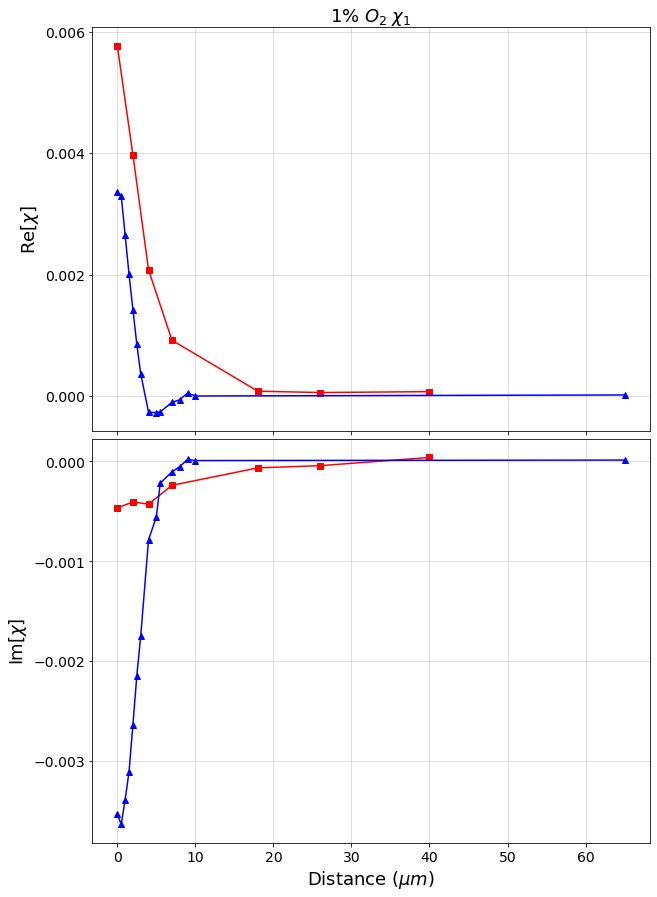

In [4]:
fig, axes = plt.subplots(nrows=2, figsize=(10,15))

# for iy in np.arange(1,sizes[0]):
#     visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
# for iy in np.arange(sizes[0]+1,sum(sizes[:2])):
#     visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
for iy in np.arange(sum(sizes[:2])+1,sum(sizes)):
    visualization.plot_chi(axes, x[iy], data1[iy], color=colors[iy], marker=markers[iy], ls='-')
axes[0].set_title('1% $O_2 \; \chi_1$', fontsize=18)
fig.subplots_adjust(hspace=0.02)
# plt.show()
# plt.savefig(r'..\\frXAS Paper Figures\\Plots\\Chi2 1%O2.png', dpi=400, bbox_inches='tight')

In [5]:
dc_data = [data1[0], data1[4], data1[8]]
dc_x = [x[0], x[4], x[8]]

In [6]:
def chi_dc(x, amp=None, ld=None, gamma=0, base=0): #(x, amp=1, ld=10, gamma=0, base=0):
    chi = amp * (np.exp(-x / ld))/(1 + gamma) + base
    return chi

In [7]:
dc_params = Parameters()
gammas = [0.068103, .102867, .23214]
for iy, (data, dum_x) in enumerate(zip(dc_data, dc_x)):
    base_inds =  dum_x > .7 * dum_x[-1]
    est_base = np.mean(data[base_inds]).real
    est_amp = (data[0].real - est_base) #/ (1 + gammas[iy])
    
    dc_params.add(f'amp_{iy+1}', value=est_amp, min=-1, max=1, vary=False)
#     dc_params.add(f'amp_{iy+1}', value=data[0].real, min=-1, max=1, vary=False)
#     dc_params.add(f'amp_{iy+1}', value=-1, vary=False)
#     dc_params[f'amp_{iy+1}'].expr = f'amp_{iy+1} - base_{iy+1}'

    dc_params.add(f'ld_{iy+1}', value=30/(iy+1), min=1e-9, max=100)
    
    dc_params.add(f'base_{iy+1}', value=est_base, min=-1, max=1)
#     dc_params.add(f'base_{iy+1}', value=1e-9, min=-1, max=11)
#     dc_params.add(f'gamma_{iy+1}', value=gammas[iy], vary=False)

dc_mini = lmfit.Minimizer(models.objective_fun, dc_params, fcn_args=(dc_x, dc_data, chi_dc))

dc_out = dc_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\20201211_processed_DC_data_UsedInThesis.txt', dc_out, starts)
print('\u03A7_red = ', dc_out.redchi)
print(fit_report(dc_out))

Χ_red =  1.913473396413916e-06
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 744
    # variables        = 6
    chi-square         = 0.00141214
    reduced chi-square = 1.9135e-06
    Akaike info crit   = -9789.96761
    Bayesian info crit = -9762.29536
[[Variables]]
    amp_1:   0.05332507 (fixed)
    ld_1:    32.8014827 +/- 0.50263332 (1.53%) (init = 30)
    base_1:  0.00273558 +/- 1.6122e-04 (5.89%) (init = 0.003466097)
    amp_2:   0.04008441 (fixed)
    ld_2:    17.1459165 +/- 0.40559479 (2.37%) (init = 15)
    base_2:  0.00139292 +/- 1.7387e-04 (12.48%) (init = 0.00136516)
    amp_3:   0.02444984 (fixed)
    ld_3:    4.97839385 +/- 0.30270277 (6.08%) (init = 10)
    base_3: -6.8188e-06 +/- 2.0557e-04 (3014.81%) (init = -3.486442e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(ld_1, base_1) = -0.770
    C(ld_2, base_2) = -0.705
    C(ld_3, base_3) = -0.552


C:\Users\shadd\Anaconda3\envs\frxas_upgrade2\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


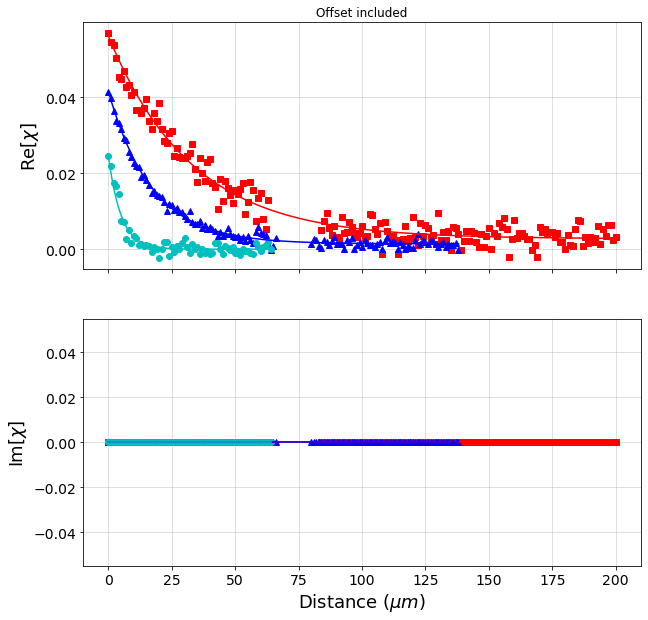

Data: 5.6791e-02 Data-base: 5.4056e-02 Amp: 5.3325e-02 Norm: 5.3325e-02 Data-base/Amp: 1.0137 Data-base/Norm: 1.0137
Data: 4.1450e-02 Data-base: 4.0057e-02 Amp: 4.0084e-02 Norm: 4.0084e-02 Data-base/Amp: 0.9993 Data-base/Norm: 0.9993
Data: 2.4415e-02 Data-base: 2.4422e-02 Amp: 2.4450e-02 Norm: 2.4450e-02 Data-base/Amp: 0.9989 Data-base/Norm: 0.9989


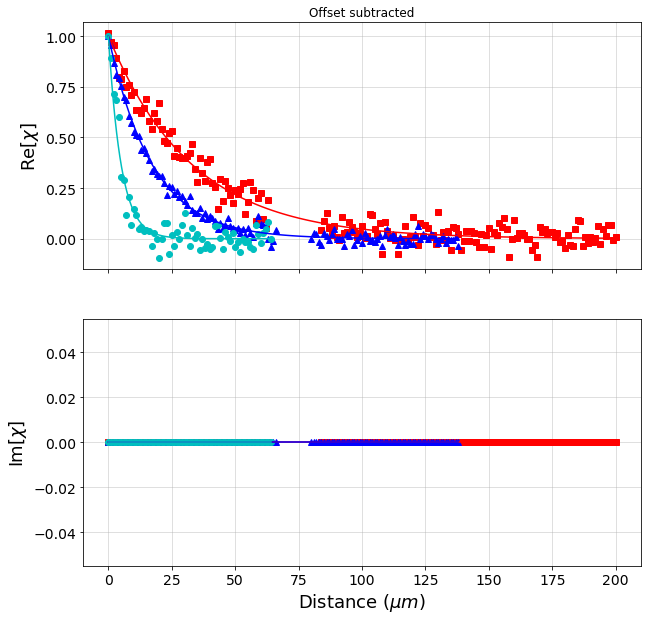

In [8]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(0, 3):
    visualization.plot_chi(axes, dc_x[iy], dc_data[iy], color=colors[iy+1],
                           marker=markers[iy+1], ls='',
                           label=f'{gases[(iy+1)*3]} bar O2')
for iy in np.arange(0, 3):
    y = np.linspace(0, dc_x[iy][-1], num=100)
    visualization.plot_chi(axes, y, models.evaluate_model_func(dc_out.params, iy, y, chi_dc),
                           color=colors[iy+1], marker='')
                           #label=str(frequencies[iy]) + ' Hz')
axes[0].set_title('Offset included')
plt.show()

fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(0, 3):
    DC_norm = 1 / (dc_out.params[f'amp_{iy+1}']) #  + dc_out.params[f'base_{iy+1}'])
    dum = dc_data[iy][0].real
    dum_nobase = dum - dc_out.params[f'base_{iy+1}'].value
    amp = dc_out.params[f'amp_{iy+1}'].value
    print(f'Data: {dum:.4e} Data-base: {dum_nobase:.4e} Amp: {amp:.4e} Norm: {1/DC_norm:.4e} Data-base/Amp: {dum_nobase/amp:.4f}'
         f' Data-base/Norm: {dum_nobase * DC_norm:.4f}')
    visualization.plot_chi(axes, dc_x[iy], (dc_data[iy] - dc_out.params[f'base_{iy+1}']) * DC_norm, color=colors[iy+1],
                           marker=markers[iy+1], ls='',
                           label=f'{gases[(iy+1)*3]} bar O2')
for iy in np.arange(0, 3):
    DC_norm = 1 / (dc_out.params[f'amp_{iy+1}']) # + dc_out.params[f'base_{iy+1}'])
    y = np.linspace(0, dc_x[iy][-1], num=100)
    visualization.plot_chi(axes, y, (models.evaluate_model_func(dc_out.params, iy, y, chi_dc) - dc_out.params[f'base_{iy+1}']) * DC_norm,
                           color=colors[iy+1], marker='')
                           #label=str(frequencies[iy]) + ' Hz')
axes[0].set_title('Offset subtracted')
plt.show()

In [9]:
import itertools
ac_data = []
ac_data.append(data1[1:4])
ac_data.append(data1[5:8])
ac_data.append(data1[9:])
ac_data = list(itertools.chain.from_iterable(a for a in ac_data))

ac_x = []
ac_x.append(x[1:4])
ac_x.append(x[5:8])
ac_x.append(x[9:])
ac_x = list(itertools.chain.from_iterable(a for a in ac_x))

ac_freqs = [0.25, 1, 4, 0.25, 1, 5, 0.5, 8]

In [10]:
ac_params = Parameters()
bound_fac = 1.5
est_amps = []
for iy, data in enumerate(ac_data[::3]):
    est_amps.append(-np.abs(data[0]/(1 + .05 * np.sqrt(1 + 1j * 2*np.pi*ac_freqs[iy]))))

for iy, data in enumerate(ac_data):
    est_amp = est_amps[int(iy/3)]
    est_min = est_amp * bound_fac
    est_max = est_amp / bound_fac
    
#     est_amp = -np.abs(data[0]/(1 + .05 * np.sqrt(1 + 1j * 2*np.pi*ac_freqs[iy])))
#     ac_params.add(f'amp_{iy+1}', value=-data[0].real, min=-1, max=-1e-3)
    ac_params.add(f'amp_{iy+1}', value=est_amp, min=est_min, max=est_max)
#     print(f'amp_{iy+1} min: {est_amp*bound_fac} max: {est_amp/bound_fac}')
    print(f'amp_{iy+1} est_amp: {est_amp} min: {est_min} max: {est_max}')
    
    ac_params.add(f'gammap_{iy+1}', value=0.055, min=1e-9, max=1)
    # setting ld to DC fit result
    ac_params.add(f'ld_{iy+1}', value=dc_out.params[f'ld_{int(iy/3)+1}'].value, vary=False)
    ac_params.add(f'tg_{iy+1}', value=1, min=1e-9, max=10.0)
    ac_params.add(f'f_{iy+1}', value=ac_freqs[iy], vary=False)
    ac_params.add(f'L_{iy+1}', value=6e-1, vary=False)

## params pinned to F1
# ac_params[f'amp_2'].expr = 'amp_1'
# ac_params[f'amp_3'].expr = 'amp_1'
# ac_params[f'amp_5'].expr = 'amp_4'
# ac_params[f'amp_6'].expr = 'amp_4'
# ac_params[f'amp_8'].expr = 'amp_7'

ac_params[f'tg_2'].expr = 'tg_1'
ac_params[f'tg_3'].expr = 'tg_1'
ac_params[f'tg_5'].expr = 'tg_4'
ac_params[f'tg_6'].expr = 'tg_4'
ac_params[f'tg_8'].expr = 'tg_7'

ac_params[f'gammap_2'].expr = 'gammap_1'
ac_params[f'gammap_3'].expr = 'gammap_1'
ac_params[f'gammap_5'].expr = 'gammap_4'
ac_params[f'gammap_6'].expr = 'gammap_4'
ac_params[f'gammap_8'].expr = 'gammap_7'

# ac_params.add(f'gammap_7', value=0.1041*2.23, vary=False)
# ac_params.add(f'gammap_8', value=0.1041*2.23, vary=False)
# ac_params.add(f'gammap_7', value=0.1041, vary=False)
# ac_params.add(f'gammap_8', value=0.1041, vary=False)
# ac_params.add(f'gammap_7', value=0, vary=False)
# ac_params.add(f'gammap_8', value=0, vary=False)
ac_mini = lmfit.Minimizer(models.objective_fun, ac_params, fcn_args=(ac_x, ac_data, models.chi_patterned))

ac_out = ac_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\ld_from_DC_FreeAmp_F3_pinned_UsedInThesis.txt', ac_out, starts)
print('\u03A7_red = ', ac_out.redchi)
print(fit_report(ac_out))

amp_1 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_2 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_3 est_amp: -0.011536777306513389 min: -0.017305165959770084 max: -0.007691184871008926
amp_4 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_5 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_6 est_amp: -0.009955459335400456 min: -0.014933189003100682 max: -0.00663697289026697
amp_7 est_amp: -0.004850445404196326 min: -0.007275668106294489 max: -0.0032336302694642174
amp_8 est_amp: -0.004850445404196326 min: -0.007275668106294489 max: -0.0032336302694642174


C:\Users\shadd\Anaconda3\envs\frxas_upgrade2\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Χ_red =  2.3273043291522122e-07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 461
    # data points      = 260
    # variables        = 14
    chi-square         = 5.7252e-05
    reduced chi-square = 2.3273e-07
    Akaike info crit   = -3957.47112
    Bayesian info crit = -3907.62158
[[Variables]]
    amp_1:    -0.01303408 +/- 2.7662e-04 (2.12%) (init = -0.01153678)
    gammap_1:  0.06809399 +/- 0.00788696 (11.58%) (init = 0.055)
    ld_1:      32.80148 (fixed)
    tg_1:      2.34478466 +/- 0.10218783 (4.36%) (init = 1)
    f_1:       0.25 (fixed)
    L_1:       0.6 (fixed)
    amp_2:    -0.01457700 +/- 3.5933e-04 (2.47%) (init = -0.01153678)
    gammap_2:  0.06809399 +/- 0.00788696 (11.58%) == 'gammap_1'
    ld_2:      32.80148 (fixed)
    tg_2:      2.34478466 +/- 0.10218783 (4.36%) == 'tg_1'
    f_2:       1 (fixed)
    L_2:       0.6 (fixed)
    amp_3:    -0.01679053 +/- 6.1471e-04 (3.66%) (init = -0.01153678)
    gammap_3:  0.06809399 +/- 0.00788696 

In [11]:
lmfit.printfuncs.report_ci(lmfit.conf_interval(dc_mini, dc_out))

           99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 ld_1  :  -1.47139  -0.98848  -0.49884  32.80148  +0.50890  +1.02899  +1.56336
 base_1:  -0.00049  -0.00033  -0.00016   0.00274  +0.00016  +0.00032  +0.00048
 ld_2  :  -1.19971  -0.80687  -0.40754  17.14592  +0.41671  +0.84365  +1.28308
 base_2:  -0.00053  -0.00035  -0.00018   0.00139  +0.00017  +0.00035  +0.00052
 ld_3  :  -0.79503  -0.54022  -0.27559   4.97839  +0.28781  +0.58948  +0.90696
 base_3:  -0.00061  -0.00041  -0.00020  -0.00001  +0.00020  +0.00040  +0.00060


In [12]:
lmfit.printfuncs.report_ci(lmfit.conf_interval(ac_mini, ac_out, sigmas=[1,2]))

C:\Users\shadd\Anaconda3\envs\frxas_upgrade2\lib\site-packages\lmfit\confidence.py:317: UserWarning: Bound reached with prob(amp_3=-0.017305165959770084) = 0.8395471834702127 < max(sigmas)
  warn(errmsg)
C:\Users\shadd\Anaconda3\envs\frxas_upgrade2\lib\site-packages\lmfit\confidence.py:317: UserWarning: Bound reached with prob(amp_7=-0.007275668106294489) = 0.0006223693460741041 < max(sigmas)
  warn(errmsg)
C:\Users\shadd\Anaconda3\envs\frxas_upgrade2\lib\site-packages\lmfit\confidence.py:317: UserWarning: Bound reached with prob(amp_8=-0.007275668106294489) = 0.0 < max(sigmas)
  warn(errmsg)


             95.45%    68.27%    _BEST_    68.27%    95.45%
 amp_1   :  -0.00050  -0.00025  -0.01303  +0.00025  +0.00050
 gammap_1:  -0.00610  -0.00307   0.06809  +0.00315  +0.00643
 tg_1    :  -0.12660  -0.06409   2.34478  +0.06608  +0.13467
 amp_2   :  -0.00054  -0.00027  -0.01458  +0.00027  +0.00054
 amp_3   :      -inf  -0.00037  -0.01679  +0.00036  +0.00073
 amp_4   :  -0.00046  -0.00023  -0.01192  +0.00023  +0.00046
 gammap_4:  -0.01544  -0.00783   0.10282  +0.00810  +0.01654
 tg_4    :  -0.08198  -0.04170   0.94623  +0.04347  +0.08909
 amp_5   :  -0.00059  -0.00029  -0.01111  +0.00029  +0.00059
 amp_6   :  -0.00109  -0.00054  -0.01005  +0.00054  +0.00109
 amp_7   :      -inf      -inf  -0.00728  +0.00058  +0.00105
 gammap_7:  -0.08706  -0.02802   0.25621  +0.03049  +0.06402
 tg_7    :  -0.02658  -0.01397   0.14271  +0.01564  +0.03334
 amp_8   :      -inf      -inf  -0.00728  +0.00008  +0.00031


In [13]:
ac_colors = ['r', 'b', 'c']
ac_markers = ['s', '^', 'o']

ac_colors = ac_colors * 3
ac_markers = ac_markers * 3

In [14]:
def calc_Dv(ld=1, tg=1, Ao=1):
    """Calculate vacancy diffusion coefficient.

    Parameters
    ----------
    ld : float
        Utilization length in microns
    tg : float
        Gerischer time constant in seconds
    Ao : float
        Thermodynamic factor; unitless.

    Returns
    -------
    dv : float
        Diffusion coefficient in units cm^2/s."""

    ld = ld * 1e-4
    dv = ld ** 2 / (Ao * tg)

    return dv


def calc_Roo(tg=1, Ao=1, xvo=.01, L=0.630):
    """Calculate exchange rate coefficient.

    Parameters
    ----------
    tg : float
        Gerischer time constant in seconds
    Ao : float
        Thermodynamic factor; unitless.
    xvo : float
        Vacancy mol fraction
    L : float
        Film thickness in microns.

    Returns
    -------
    roo : float
        Exchange rate coefficient in units mol cm^-2 s^-1."""

    L = L * 1e-4 # um to cm
    co = 3 / 33.7 # mol cm^-3
    roo = co * L * xvo / (4 * tg * Ao)

    return roo

In [15]:
Aos = [2.6894, 2.6894, 2.6894, 2.0881, 2.0881, 2.0881, 1.6732, 1.6732]
xvos = [0.020081, 0.020081, 0.020081, 0.013103, 0.013103, 0.013103, 0.007532, 0.007532]
dvs = []
roos = []
for i in [1, 4, 7]:# enumerate(ac_data):
    ld = ac_out.params[f'ld_{i}'].value
    tg = ac_out.params[f'tg_{i}'].value
    
    dv = calc_Dv(ld=ld, tg=tg, Ao=Aos[i])
    dvs.append(dv)
    roo = calc_Roo(tg=tg, Ao=Aos[i], xvo=xvos[i])
    roos.append(roo)
    print(f'Dv = {dv:.3e} cm^2/s Roo = {roo:.3e} mol / cm^2 / s')

Dv = 1.706e-06 cm^2/s Roo = 4.465e-09 mol / cm^2 / s
Dv = 1.488e-06 cm^2/s Roo = 9.298e-09 mol / cm^2 / s
Dv = 1.038e-06 cm^2/s Roo = 4.423e-08 mol / cm^2 / s


In [16]:
dv = 1.02e-6
roo = 4.36e-8
ao = 1.67
tg = 0.14271 #0.145
ld = .00049784#.000498
co = 3/33.7
L = 0.63 * 1e-4
xvo = 0.007532

print(f'ld is: {np.sqrt(dv*ao*tg):.3e}')
print(f'tg is: {ld**2 / (ao * dv):.3e}')
print(f'Dv is: {ld**2 / (ao * tg):.3e}')
print('-----')
print(f'Roo is: {co * L * xvo / (4 * tg * ao)}')
print(f'tg is: {co * L * xvo / (4 * roo * ao)}')
print(f'Ao is: {co * L * xvo / (4 * tg * roo)}')

    # L = L * 1e-4
    # co = 3 / 33.7
    # roo = co * L * xvo / (4 * tg * Ao)

ld is: 4.930e-04
tg is: 1.455e-01
Dv is: 1.040e-06
-----
Roo is: 4.431097906712354e-08
tg is: 0.1450371518960826
Ao is: 1.697232455093952


# Plotting scaled profiles

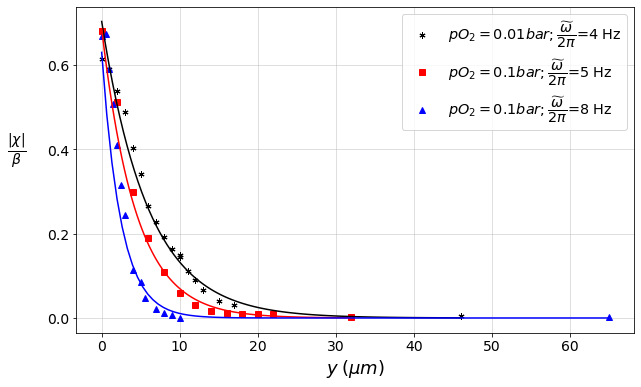

In [17]:
# Magnitude profiles of highest freq from each pO2.

fig, ax = plt.subplots(figsize=(10,6))
plot_indices = [2, 5, 7]
# Plotting with chi scaled to beta (fit amplitude)
for j, iy in enumerate(plot_indices):
    beta = -1 * ac_out.params[f'amp_{iy+1}']
    psi_at_gate = models.evaluate_model_func(ac_out.params, iy, 0, models.chi_patterned)
    normalized_data_val =np.abs(ac_data[iy] / beta)   
    omega = ac_freqs[iy] * 2 * np.pi
    
    visualization.plot_chi_mag(
        ax,
        ac_x[iy],
        normalized_data_val,
        color=colors[j],
        marker=markers[j],
        ls='',
        label=f'$pO_2 = {gases[iy]} bar;' + ' \dfrac{\widetilde{\omega}}{2\pi}$=' + f'{ac_freqs[iy]} Hz'
    )
    
for j, iy in enumerate(plot_indices):
    omega = ac_freqs[iy] * 2 * np.pi
    y = np.linspace(0, ac_x[iy][-1], num=100)
    beta = -1 * ac_out.params[f'amp_{iy+1}']
    psi_at_gate = models.evaluate_model_func(ac_out.params, iy, 0, models.chi_patterned)
    normalized_model_val = (
        np.abs(
            models.evaluate_model_func(ac_out.params, iy, y, models.chi_patterned) /
            beta # psi_at_gate
        )
    )
    visualization.plot_chi_mag(
        ax,
        y,
        normalized_model_val,
        color=colors[j],
        marker=''
    )

ax.set_ylabel(r'$\frac{|\chi|}{\beta}}$', rotation=0, labelpad=30, fontsize=20)
ax.set_xlabel(r'$y \: (\mu m)$')

fig.subplots_adjust(hspace=0.02)
plt.legend(fontsize='x-large')
# plt.show()
# plt.savefig(r'../frXAS_2nd_Paper/Plots/Profiles/Pattern_Amp_Model_Xmag_vs_y_parametric_f.svg', dpi=400, bbox_inches='tight')

(-12.595904605494047, 264.51399671537496)


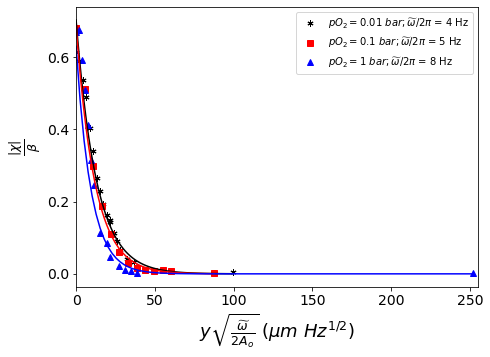

In [18]:
# Magnitude profiles of highest freq from each pO2.
# y-axis scaled by beta (fit amplitude)
# x-axis scaled by sqrt(omega / 2 Ao)

fig, ax = plt.subplots(figsize=(7.2, 5.14))
plot_indices = [2, 5, 7]
scales = []
for j, iy in enumerate(plot_indices):
    beta = -1 * ac_out.params[f'amp_{iy+1}']
    normalized_data_val = np.abs(ac_data[iy] / beta)     
    scale = np.sqrt(ac_freqs[iy] * 2 * np.pi / (2 * Aos[iy]))
    scales.append(scale)
    visualization.plot_chi_mag(
        ax,
        ac_x[iy] * scale,
        normalized_data_val,
        color=colors[j],
        marker=markers[j],
        ls='',
        label=f'$pO_2 = {gases[iy+1]}\ bar;$' + '$\widetilde{\omega}/2\pi$ = ' + f'{ac_freqs[iy]} Hz'
    )
    
for j, iy in enumerate(plot_indices):
    y = np.linspace(0, ac_x[iy][-1], num=100)
    beta = -1 * ac_out.params[f'amp_{iy+1}']

    normalized_model_val = (
        np.abs(
            models.evaluate_model_func(ac_out.params, iy, y, models.chi_patterned) /
            beta
        )
    )
    visualization.plot_chi_mag(
        ax,
        y * scales[j],
        normalized_model_val,
        color=colors[j],
        marker=''
    )

ax.set_ylabel(r'$\frac{|\chi|}{\beta}$')#, rotation=0, labelpad=30, fontsize=20)
ax.set_xlabel(r'$y \sqrt{\frac{\widetilde{\omega}}{2A_o}}\: (\mu m \ Hz^{1/2})$')
ax.grid(False)
print(ax.get_xlim())
ax.set_xlim(0, 255)

fig.subplots_adjust(hspace=0.02)
plt.legend()#fontsize='x-large')
# plt.show()
# plt.savefig(r'../frXAS Paper Figures/Plots/Profiles/Pattern_Amp_Model_highFreq_Xmag_vs_yw-2Ao_parametric_pO2.png', dpi=400, bbox_inches='tight')
# plt.savefig(r'../frXAS Paper Figures/Plots/Profiles/Pattern_Amp_Model_highFreq_Xmag_vs_yw-2Ao_parametric_pO2.svg', dpi=400, bbox_inches='tight')

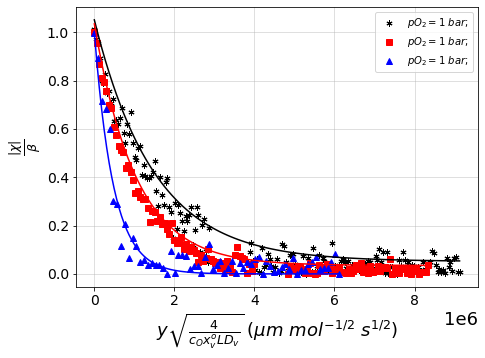

In [19]:
# Magnitude profiles of steady-state from each pO2.
# y-axis scaled by beta (fit amplitude)
# x-axis scaled by sqrt(4 / xvo * co * L * Dv)

fig, ax = plt.subplots(figsize=(7.2, 5.14))
co = 3 / 33.7 * 1e-4**2 # mol um^-3
L = 0.630 # um
xvos_po2 = [0.020081, 0.013103, 0.007532]
scales = []

for j, (dc_pos, dc_chi) in enumerate(zip(dc_x, dc_data)): 
    beta = 1 * dc_out.params[f'amp_{j+1}']
    base = dc_out.params[f'base_{j+1}']
    normalized_data_val = (dc_chi - base) / beta   
    scale = np.sqrt(4 / (xvos_po2[j] * co * L * dvs[j] * 1e4**2))  # mol^-1/2 s^1/2
    scales.append(scale)

    visualization.plot_chi_mag(
        ax,
        dc_pos * scale, 
        normalized_data_val,
        color=colors[j],
        marker=markers[j],
        ls='',
        label=f'$pO_2 = {gases[iy+1]}\ bar;$'
    )
    
for j, (dc_pos, dc_chi) in enumerate(zip(dc_x, dc_data)):
    y = np.linspace(0, dc_pos[-1], num=100)
    beta = 1 * dc_out.params[f'amp_{j+1}']

    normalized_model_val = np.abs(
            (models.evaluate_model_func(dc_out.params, j, y, chi_dc) - base) /
            beta
        )
    visualization.plot_chi_mag(
        ax,
        y * scales[j],
        normalized_model_val,
        color=colors[j],
        marker=''
    )

ax.set_ylabel(r'$\frac{|\chi|}{\beta}$')#, rotation=0, labelpad=30, fontsize=20)
ax.set_xlabel(r'$y \sqrt{\frac{4}{c_Ox^o_vLD_v}}\: (\mu m \ mol^{-1/2} \ s^{1/2})$')
# ax.grid(False)
# print(ax.get_xlim())
# ax.set_xlim(0, 255)

fig.subplots_adjust(hspace=0.02)
plt.legend()#fontsize='x-large')
# plt.show()
# plt.savefig(r'../frXAS Paper Figures/Plots/Profiles/Pattern_Amp_Model_SS_Xmag_vs_y4-xvoLcoDv_parametric_pO2.png', dpi=400, bbox_inches='tight')
# plt.savefig(r'../frXAS Paper Figures/Plots/Profiles/Pattern_Amp_Model_SS_Xmag_vs_y4-xvoLcoDv_parametric_pO2.svg', dpi=400, bbox_inches='tight')

## Fitting 1 exponential through all high freq profiles to get Dv

In [20]:
def chi_warburg_limit_mag(y, gamma=1e-3, Dv=1e-6, amp=1, Ao=1, f=1):
    """
    NOTE: Dv is cm^2 s^-1; f is Hz
    """
    g_p = gamma
    w = 2 * np.pi * f
    chi = amp / (g_p * np.sqrt(w / (Ao * Dv))) * np.exp(-y * np.sqrt(w / (2 * Ao * Dv)))
    return chi

In [21]:
warburg_lim_chi = [np.abs(data1[3]), np.abs(data1[7]), np.abs(data1[10][0:])]
# warburg_lim_chi = [np.abs(data1[3] / warburg_lim_betas[0]), np.abs(data1[7] / warburg_lim_betas[1]), np.abs(data1[10][0:] / warburg_lim_betas[2])]
warburg_lim_freq = [frequencies[3], frequencies[7], frequencies[10]]
warburg_lim_pos = [x[3], x[7], x[10][0:]]
warburg_lim_betas = [-ac_out.params['amp_3'].value, -ac_out.params['amp_6'].value, -ac_out.params['amp_8'].value]
warburg_lim_aos = [Aos[0], Aos[3], Aos[7]]

warburg_lim_params = Parameters()
bound_fac = 1.5

for i, _ in enumerate(warburg_lim_chi):
    warburg_lim_params.add(f'gamma_{i+1}', value=0.055, min=1e-12) #, max=1)
    warburg_lim_params.add(f'Dv_{i+1}', value=1.5e2, min=1e-8, max=1e4)
    warburg_lim_params.add(f'amp_{i+1}', value=warburg_lim_betas[i], vary=False)
    warburg_lim_params.add(f'Ao_{i+1}', value=warburg_lim_aos[i], vary=False)
    warburg_lim_params.add(f'f_{i+1}', value=warburg_lim_freq[i], vary=False)

warburg_lim_params[f'Dv_2'].expr = 'Dv_1'
warburg_lim_params[f'Dv_3'].expr = 'Dv_1'

wl_mini = lmfit.Minimizer(models.objective_fun, warburg_lim_params, fcn_args=(warburg_lim_pos, warburg_lim_chi, chi_warburg_limit_mag))

wl_out = wl_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\ld_from_DC_FreeAmp_F3_pinned_UsedInThesis.txt', ac_out, starts)
print('\u03A7_red = ', wl_out.redchi)
print(fit_report(wl_out))

Χ_red =  1.8640645518668086e-07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 46
    # variables        = 4
    chi-square         = 7.8291e-06
    reduced chi-square = 1.8641e-07
    Akaike info crit   = -708.970172
    Bayesian info crit = -701.655606
[[Variables]]
    gamma_1:  6.32444621 +/- 0.34399021 (5.44%) (init = 0.055)
    Dv_1:     181.843955 +/- 13.0345409 (7.17%) (init = 150)
    amp_1:    0.01679053 (fixed)
    Ao_1:     2.6894 (fixed)
    f_1:      4 (fixed)
    gamma_2:  5.01939121 +/- 0.33257749 (6.63%) (init = 0.055)
    Dv_2:     181.843955 +/- 13.0345409 (7.17%) == 'Dv_1'
    amp_2:    0.01005454 (fixed)
    Ao_2:     2.0881 (fixed)
    f_2:      5 (fixed)
    gamma_3:  3.52163232 +/- 0.23084337 (6.56%) (init = 0.055)
    Dv_3:     181.843955 +/- 13.0345409 (7.17%) == 'Dv_1'
    amp_3:    0.007275668 (fixed)
    Ao_3:     1.6732 (fixed)
    f_3:      8 (fixed)
[[Correlations]] (unreported correlations are < 

(-12.595904605494047, 264.51399671537496)


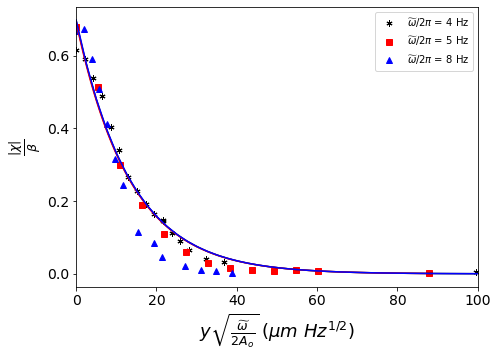

In [22]:
fig, ax = plt.subplots(figsize=(7.2, 5.14))
scales = []
for i, _ in enumerate(warburg_lim_chi):
    beta = warburg_lim_betas[i] 
    normalized_data_val = np.abs(warburg_lim_chi[i] / beta)     
    scale = np.sqrt(warburg_lim_freq[i] * 2 * np.pi / (2 * warburg_lim_aos[i]))
    scales.append(scale)
    visualization.plot_chi_mag(
        ax,
        warburg_lim_pos[i] * scale,
        normalized_data_val,
        color=colors[i],
        marker=markers[i],
        ls='',
        label='$\widetilde{\omega}/2\pi$ = ' + f'{warburg_lim_freq[i]} Hz'
    )
    
for i, _ in enumerate(warburg_lim_chi):
    pos = np.linspace(0, warburg_lim_pos[i][-1], num=101)
    beta = warburg_lim_betas[i]

    normalized_model_val = (
        np.abs(
            models.evaluate_model_func(wl_out.params, i, pos, chi_warburg_limit_mag) /
            beta
        )
    )
    visualization.plot_chi_mag(
        ax,
        pos * scales[i],
        normalized_model_val,
        color=colors[i],
        marker=''
    )

ax.set_ylabel(r'$\frac{|\chi|}{\beta}$')#, rotation=0, labelpad=30, fontsize=20)
ax.set_xlabel(r'$y \sqrt{\frac{\widetilde{\omega}}{2A_o}}\: (\mu m \ Hz^{1/2})$')
ax.grid(False)
print(ax.get_xlim())
ax.set_xlim(0, 100)

fig.subplots_adjust(hspace=0.02)
plt.legend()#fontsize='x-large')
# plt.show()
# plt.savefig(r'../frXAS Paper Figures/Plots/Profiles/Pattern_Amp_Model_highFreq_Xmag_vs_yw-2Ao_parametric_pO2.png', dpi=400, bbox_inches='tight')
# plt.savefig(r'../frXAS Paper Figures/Plots/Profiles/Pattern_Amp_Model_highFreq_Xmag_vs_yw-2Ao_parametric_pO2.svg', dpi=400, bbox_inches='tight')

In [27]:
gases

[0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 1, 1, 1]

In [47]:
warburg_lim_chi = [np.abs(data1[3]), np.abs(data1[7]), np.abs(data1[10][0:])]
# warburg_lim_chi = [np.abs(data1[3] / warburg_lim_betas[0]), np.abs(data1[7] / warburg_lim_betas[1]), np.abs(data1[10][0:] / warburg_lim_betas[2])]
warburg_lim_freq = [frequencies[3], frequencies[7], frequencies[10]]
warburg_lim_pos = [x[3], x[7], x[10][0:]]
warburg_lim_betas = [-ac_out.params['amp_3'].value, -ac_out.params['amp_6'].value, -ac_out.params['amp_8'].value]
warburg_lim_aos = [Aos[0], Aos[3], Aos[7]]
warburg_lim_gases = [gases[3], gases[7], gases[10]]

warburg_lim_scaled_chi = []
warburg_lim_scaled_pos = []
scales = {"chi": [], "pos": []}
for i, data in enumerate(warburg_lim_chi):
    chi_scale = np.sqrt(2 * np.pi * warburg_lim_freq[i])# / warburg_lim_betas[i] # / warburg_lim_aos[i]) / warburg_lim_betas[i]
    pos_scale = np.sqrt(2 * np.pi * warburg_lim_freq[i] / (2 * warburg_lim_aos[i]))
    scales["chi"].append(chi_scale)
    scales["pos"].append(pos_scale)
    print(chi_scale, pos_scale)
    for chi, pos in zip(data, warburg_lim_pos[i]):
        warburg_lim_scaled_chi.append(chi * chi_scale)
        warburg_lim_scaled_pos.append(pos * pos_scale)
        
warburg_lim_scaled_chi = np.array(warburg_lim_scaled_chi)
warburg_lim_scaled_pos = np.array(warburg_lim_scaled_pos)

warburg_lim_scaled_chi = warburg_lim_scaled_chi[np.argsort(warburg_lim_scaled_pos)]
warburg_lim_scaled_pos = warburg_lim_scaled_pos[np.argsort(warburg_lim_scaled_pos)]

5.0132565492620005 2.1616094571439675
5.604991216397929 2.7427377992585296
7.0898154036220635 3.8756629555366295


In [48]:
def chi_warburg_lim_scaled(y_scaled, amp=1, Dv=1e2): #gamma=5, Dv=1e2):
    return amp * np.exp(-y_scaled / np.sqrt(Dv))
    # return 1 / (gamma * np.sqrt(Dv)) * np.exp(-y_scaled / np.sqrt(Dv))

warburg_lim_scaled_params = Parameters()

warburg_lim_scaled_params.add(f'amp_1', value=0.055, min=1e-10)
# warburg_lim_scaled_params.add(f'gamma_1', value=0.055, min=-1) #, max=1)
warburg_lim_scaled_params.add(f'Dv_1', value=1.5e2, min=1e-10) #, max=1e4)

wl_mini = lmfit.Minimizer(models.objective_fun, warburg_lim_scaled_params, fcn_args=(warburg_lim_scaled_pos, warburg_lim_scaled_chi, chi_warburg_lim_scaled))

wl_out = wl_mini.minimize(method='leastsq')

# save_fit_report(f'..\\Fit Reports\\ld_from_DC_FreeAmp_F3_pinned_UsedInThesis.txt', ac_out, starts)
print(fit_report(wl_out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 46
    # variables        = 2
    chi-square         = 0.00131912
    reduced chi-square = 2.9980e-05
    Akaike info crit   = -477.134013
    Bayesian info crit = -473.476730
[[Variables]]
    amp_1:  0.04599229 +/- 0.00237138 (5.16%) (init = 0.055)
    Dv_1:   175.383370 +/- 31.0451581 (17.70%) (init = 150)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp_1, Dv_1) = -0.640


(-12.595904605494047, 264.51399671537496)


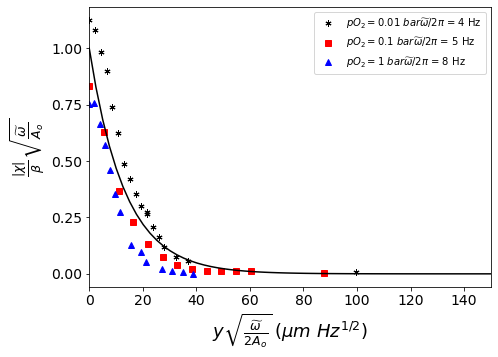

In [50]:
fig, ax = plt.subplots(figsize=(7.2, 5.14))

for i, _ in enumerate(warburg_lim_chi):
    chi_scale = scales["chi"][i]
    pos_scale = scales["pos"][i]
    visualization.plot_chi_mag(
        ax,
        warburg_lim_pos[i] * pos_scale,
        warburg_lim_chi[i] * chi_scale / wl_out.params['amp_1'].value,
        color=colors[i],
        marker=markers[i],
        ls='',
        label=f'$pO_2 = {warburg_lim_gases[i]}\ bar$' + '$\widetilde{\omega}/2\pi$ = ' + f'{warburg_lim_freq[i]} Hz'
        # '$\widetilde{\omega}/2\pi$ = ' + f'{warburg_lim_freq[i]} Hz'
    )
    
pos = np.linspace(0, warburg_lim_scaled_pos.max(), num=101)
model_val = models.evaluate_model_func(wl_out.params, 0, pos, chi_warburg_lim_scaled) / wl_out.params['amp_1'].value

visualization.plot_chi_mag(
    ax,
    pos,
    model_val,
    color=colors[0],
    marker=''
)

ax.set_ylabel(r'$\frac{|\chi|}{\beta} \sqrt{\frac{\widetilde{\omega}}{A_o}}$')#, rotation=0, labelpad=30, fontsize=20)
ax.set_xlabel(r'$y \sqrt{\frac{\widetilde{\omega}}{2A_o}}\: (\mu m \ Hz^{1/2})$')
ax.grid(False)
print(ax.get_xlim())
ax.set_xlim(0, 150)

fig.subplots_adjust(hspace=0.02)
plt.legend()#fontsize='x-large')
# plt.show()
# plt.savefig(r'../frXAS Paper Figures/Plots/Profiles/Pattern_Amp_Model_highFreq_Xmag_vs_yw-2Ao_parametric_pO2.png', dpi=400, bbox_inches='tight')
# plt.savefig(r'../frXAS Paper Figures/Plots/Profiles/Pattern_Amp_Model_highFreq_Xmag_vs_yw-2Ao_parametric_pO2.svg', dpi=400, bbox_inches='tight')

In [36]:
for i, (freq, tg) in enumerate(zip(warburg_lim_freq, [2.34, 0.946, 0.145])):
    full = np.sqrt(1 + tg * 2 * np.pi * freq)
    abbv = np.sqrt(tg * np.pi * 2 * freq)
    err = (abbv - full) / full * 100
    print(f'Full {full}  Approx {abbv}  Error {err}')

Full 7.733732247446954  Approx 7.668807891400131  Error -0.8394957824956544
Full 5.542514456720834  Approx 5.451556337685546  Error -1.6410984535185549
Full 2.8789746362773534  Approx 2.699721273822229  Error -6.226291826138041


## Using Dv from fitting above to scale steady-state profiles

In [112]:
dc_out

In [63]:
ss_lim_chi = [np.abs(dc_data[0]), np.abs(dc_data[1]), np.abs(dc_data[2][0:])]
ss_lim_pos = [dc_x[0], dc_x[1], dc_x[2][0:]]
ss_lim_betas = [dc_out.params['amp_1'].value, dc_out.params['amp_2'].value, dc_out.params['amp_3'].value]
ss_lim_aos = [Aos[0], Aos[3], Aos[7]]
ss_lim_xvos = [xvos[0], xvos[3], xvos[7]]
ss_lim_gases = [gases[3], gases[7], gases[10]]
co = 3 / 33.7 * 1e-4**2 # mol um^-3
L = 0.630 # um

ss_lim_scaled_chi = []
ss_lim_scaled_pos = []
ss_scales = {"chi": [], "pos": []}
for i, data in enumerate(ss_lim_chi):
    chi_scale = 1 / ss_lim_betas[i]
    pos_scale = np.sqrt(4 / (ss_lim_xvos[i] * co * L * wl_out.params['Dv_1'].value))
    ss_scales["pos"].append(pos_scale)
    ss_scales["chi"].append(chi_scale)
    print(chi_scale, pos_scale)
    # for chi, pos in zip(data, ss_lim_pos[i]):
        # ss_lim_scaled_chi.append(chi * chi_scale)
        # ss_lim_scaled_pos.append(pos * pos_scale)
    ss_lim_scaled_chi.append(data * chi_scale)
    ss_lim_scaled_pos.append(ss_lim_pos[i] * pos_scale)
        
# ss_lim_scaled_chi = np.array(ss_lim_scaled_chi)
# ss_lim_scaled_pos = np.array(ss_lim_scaled_pos)

# ss_lim_scaled_chi = ss_lim_scaled_chi[np.argsort(ss_lim_scaled_pos)]
# ss_lim_scaled_pos = ss_lim_scaled_pos[np.argsort(ss_lim_scaled_pos)]

18.75290430981254 45001.518654780295
24.94735629313762 55710.16793420927
40.900064103675824 73479.24452151681


In [64]:
ss_lim_scaled_pos

[array([      0.        ,   45001.51865478,   90003.03730956,
         135004.55596434,  180006.07461912,  225007.5932739 ,
         270009.11192868,  315010.63058346,  360012.14923824,
         405013.66789302,  450015.1865478 ,  495016.70520258,
         540018.22385736,  585019.74251214,  630021.26116692,
         675022.7798217 ,  720024.29847648,  765025.81713127,
         810027.33578605,  855028.85444083,  900030.37309561,
         945031.89175039,  990033.41040517, 1035034.92905995,
        1080036.44771473, 1125037.96636951, 1170039.48502429,
        1215041.00367907, 1260042.52233385, 1305044.04098863,
        1350045.55964341, 1395047.07829819, 1440048.59695297,
        1485050.11560775, 1530051.63426253, 1575053.15291731,
        1620054.67157209, 1665056.19022687, 1710057.70888165,
        1755059.22753643, 1800060.74619121, 1845062.26484599,
        1890063.78350077, 1935065.30215555, 1980066.82081033,
        2025068.33946511, 2070069.85811989, 2115071.37677467,
        

(-12.595904605494047, 264.51399671537496)


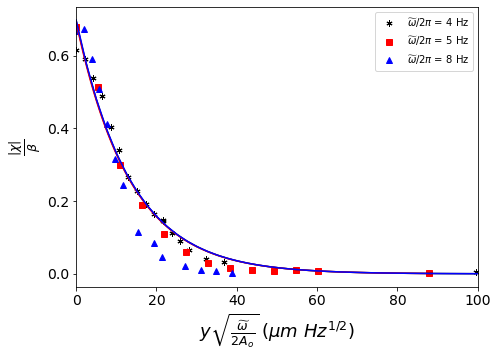

In [99]:
fig, ax = plt.subplots(figsize=(7.2, 5.14))

scales = []
for i, _ in enumerate(warburg_lim_chi):
    beta = warburg_lim_betas[i] 
    normalized_data_val = np.abs(warburg_lim_chi[i] / beta)     
    scale = np.sqrt(warburg_lim_freq[i] * 2 * np.pi / (2 * warburg_lim_aos[i]))
    scales.append(scale)
    visualization.plot_chi_mag(
        ax,
        warburg_lim_pos[i] * scale,
        normalized_data_val,
        color=colors[i],
        marker=markers[i],
        ls='',
        label='$\widetilde{\omega}/2\pi$ = ' + f'{warburg_lim_freq[i]} Hz'
    )
    
for i, _ in enumerate(warburg_lim_chi):
    pos = np.linspace(0, warburg_lim_pos[i][-1], num=101)
    beta = warburg_lim_betas[i]

    normalized_model_val = (
        np.abs(
            models.evaluate_model_func(wl_out.params, i, pos, chi_warburg_limit_mag) /
            beta
        )
    )
    visualization.plot_chi_mag(
        ax,
        pos * scales[i],
        normalized_model_val,
        color=colors[i],
        marker=''
    )

ax.set_ylabel(r'$\frac{|\chi|}{\beta}$')#, rotation=0, labelpad=30, fontsize=20)
ax.set_xlabel(r'$y \sqrt{\frac{\widetilde{\omega}}{2A_o}}\: (\mu m \ Hz^{1/2})$')
ax.grid(False)
print(ax.get_xlim())
ax.set_xlim(0, 100)

fig.subplots_adjust(hspace=0.02)
plt.legend()#fontsize='x-large')
# plt.show()
# plt.savefig(r'../frXAS Paper Figures/Plots/Profiles/Pattern_Amp_Model_highFreq_Xmag_vs_yw-2Ao_parametric_pO2.png', dpi=400, bbox_inches='tight')
# plt.savefig(r'../frXAS Paper Figures/Plots/Profiles/Pattern_Amp_Model_highFreq_Xmag_vs_yw-2Ao_parametric_pO2.svg', dpi=400, bbox_inches='tight')